# Part 5: k-fold Cross Validation with SVM

In [4]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [5]:
# Run some setup code for this notebook.
import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import ipywidgets as widgets

from ipywidgets import VBox, HBox, Layout
from sklearn import svm
from sklearn import neighbors
from sklearn import preprocessing
from sklearn.utils import shuffle
from sklearn.model_selection import cross_val_score

from sklearn.metrics import roc_curve, auc, roc_auc_score
from scipy import interp

from utils.checkbox import *
from utils.data_utils import *
#from utils.data_processing import *
from utils.svm_modeling import *
from utils.model_eval import *
from __future__ import print_function

# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (15.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
# Load data.
path = 'dataset_new'
feature_dict = load_features(path, dont_show=True)
#show_feature_details(feature_dict)

Feature dict loaded.



In [7]:
# Select some features.
use_all = False
#use_all = True

group_1 = [7, 23, 41]
group_2 = [7, 23, 41, 29, 55, 22]
group_3 = [7, 23, 41, 29, 55, 22, 25, 15, 35]
new_group_1 = [7, 23, 41]
new_group_2 = [7, 23, 41, 25, 15]
new_group_3 = [7, 23, 41, 25, 15, ]
include_feature_groups = []
include_feature_index = group_2
exclude_feature_index = []

if use_all:
    include_feature_index = np.arange(1, len(feature_dict), 1)

feature_pre_selected = pre_select_feature(include_feature_groups, include_feature_index, exclude_feature_index, dont_show=True)
precheck_boxes = generate_precheck_boxes(feature_pre_selected, feature_dict, dont_show=True)

hbox = gen_checkbox(precheck_boxes, feature_dict)
HBox(hbox)

HBox(children=(VBox(children=(Checkbox(value=False, description='1_24h_urinary_microalbumin'), Checkbox(value=False, description='2_24h_urine_protein'), Checkbox(value=False, description='3_25oh_vd'), Checkbox(value=False, description='4_25oh_vd3'), Checkbox(value=False, description='5_2h_fasting_glucose'), Checkbox(value=False, description='6_8_blood_cortisol'), Checkbox(value=True, description='7_age'), Checkbox(value=False, description='8_alt'), Checkbox(value=False, description='9_ast'), Checkbox(value=False, description='10_blood_protein'), Checkbox(value=False, description='11_blood_urea_nitrogen'), Checkbox(value=False, description='12_blood_uric_acid'), Checkbox(value=False, description='13_c_peptide'), Checkbox(value=False, description='14_c_reactive_protein'), Checkbox(value=False, description='15_calf'))), VBox(children=(Checkbox(value=False, description='16_creatine_kinase'), Checkbox(value=False, description='17_creatinine'), Checkbox(value=False, description='18_cystatin_c'), Checkbox(value=False, description='19_fasting_glucose'), Checkbox(value=False, description='20_fasting_insulin'), Checkbox(value=False, description='21_ft3'), Checkbox(value=True, description='22_ft4'), Checkbox(value=True, description='23_gender'), Checkbox(value=False, description='24_glycated_hemoglobin'), Checkbox(value=False, description='25_grip_strength'), Checkbox(value=False, description='26_hbg'), Checkbox(value=False, description='27_hdlc'), Checkbox(value=False, description='28_height'), Checkbox(value=True, description='29_movement_hours'), Checkbox(value=False, description='30_plt'))), VBox(children=(Checkbox(value=False, description='31_pth'), Checkbox(value=False, description='32_rbc'), Checkbox(value=False, description='33_sleep_time'), Checkbox(value=False, description='34_total_cholesterol'), Checkbox(value=False, description='35_triglyceride'), Checkbox(value=False, description='36_tsh'), Checkbox(value=False, description='37_wbc'), Checkbox(value=False, description='38_weight'), Checkbox(value=False, description='39_h2'), Checkbox(value=False, description='40_6m_speed'), Checkbox(value=True, description='41_bmi'), Checkbox(value=False, description='42_history_of_fall'), Checkbox(value=False, description='43_history_of_cerebrovascular_disease'), Checkbox(value=False, description='44_course_of_diabetes'), Checkbox(value=False, description='45_exogenous_insulin'))), VBox(children=(Checkbox(value=False, description='46_oral_antidiabetic_drug'), Checkbox(value=False, description='47_hypertension_duration'), Checkbox(value=False, description='48_history_of_coronary_heart_disease'), Checkbox(value=False, description='49_ldlc'), Checkbox(value=False, description='50_smoking_history'), Checkbox(value=False, description='51_has_hypertension'), Checkbox(value=False, description='52_do_exercise'), Checkbox(value=False, description='53_sulfonylureas'), Checkbox(value=False, description='54_non_sulfonylureas'), Checkbox(value=True, description='55_biguanides'), Checkbox(value=False, description='56_glycosidase_inhibitor'), Checkbox(value=False, description='57_chinese_medicine'), Checkbox(value=False, description='58_thiazolidinediones'), Checkbox(value=False, description='59_glp1ddp4'), Checkbox(value=False, description='60_job_worker'))), VBox(children=(Checkbox(value=False, description='61_noon_nap'), Checkbox(value=False, description='62_snore'), Checkbox(value=False, description='63_chewing_ability'), Checkbox(value=False, description='64_fundal_photograph'), Checkbox(value=False, description='65_dpn'), Checkbox(value=False, description='66_lower_limb_doppler'), Checkbox(value=False, description='997_blood_Ca')))))

In [8]:
# Turn on / off log.

#use_log = False
use_log = False

# Load data.
checked_features = review_checkbox(hbox, dont_show=False, log=use_log)
X = load_using_features(feature_dict, checked_features, dont_show=True)
asm, asm_h2, sarcopenia, gender, height_squared, patient_id = load_asm(), load_asm_over_h2(), load_sarcopenia(), load_gender(), load_height_squared(), load_index()

# Random shuffle. Comment this line if you want to keep the shuffling order.
shuffle_index = np.random.permutation(X.shape[0])

X = X[shuffle_index]; asm = asm[shuffle_index]; asm_h2 = asm_h2[shuffle_index]; sarcopenia = sarcopenia[shuffle_index];
gender = gender[shuffle_index]; height_squared = height_squared[shuffle_index]; patient_id = patient_id[shuffle_index];

# Data Rescaling.
scaler = set_scaler()

# k-fold Splitting
n_fold = 5
items_per_fold = int(X.shape[0] / n_fold)
train_fold_mask = []
val_fold_mask = []
mask_cv = np.arange(0, 132)
masks = []
for i in np.arange(0, n_fold):
    masks.append(np.split(mask_cv, [i * items_per_fold, (i+1) * items_per_fold]))
    
for i in np.arange(0, n_fold): 
    train_fold_mask.append(np.concatenate([masks[i][0], masks[i][2]]))
    val_fold_mask.append(masks[i][1])
    #print(val_fold_mask[i])
    #print(train_fold_mask[i])

Checked features:
  [7, 22, 23, 29, 41, 55]
Loading (6) features, done.


## k-fold test for SVM


## Method I: SVM Classifier on Sarcopenia (k-fold)

------------------------ Fold 1 --------------------------

Evaluating Test set:
Positive: 8, Negative: 18
TP: 3, FP: 0, TN: 18, FN: 5
Correct: 21(26), Precision: 1.000, Recall: 0.375, Specificity: 1.000, F1-Score: 0.545

[0.         0.         0.         0.11111111 0.11111111 0.27777778
 0.27777778 0.44444444 0.44444444 0.83333333 0.83333333 1.        ]
[0.    0.125 0.5   0.5   0.625 0.625 0.75  0.75  0.875 0.875 1.    1.   ]
[1.87042134 0.87042134 0.57020062 0.46893396 0.3541643  0.25154531
 0.23962696 0.14530527 0.13287275 0.10053541 0.07491097 0.01569924]
------------------------ Fold 2 --------------------------

Evaluating Test set:
Positive: 7, Negative: 19
TP: 2, FP: 2, TN: 17, FN: 5
Correct: 19(26), Precision: 0.500, Recall: 0.286, Specificity: 0.895, F1-Score: 0.364

[0.         0.         0.         0.15789474 0.15789474 0.21052632
 0.21052632 0.26315789 0.26315789 0.31578947 0.31578947 0.42105263
 0.42105263 1.        ]
[0.         0.14285714 0.28571429 0.28571429 0.4285714

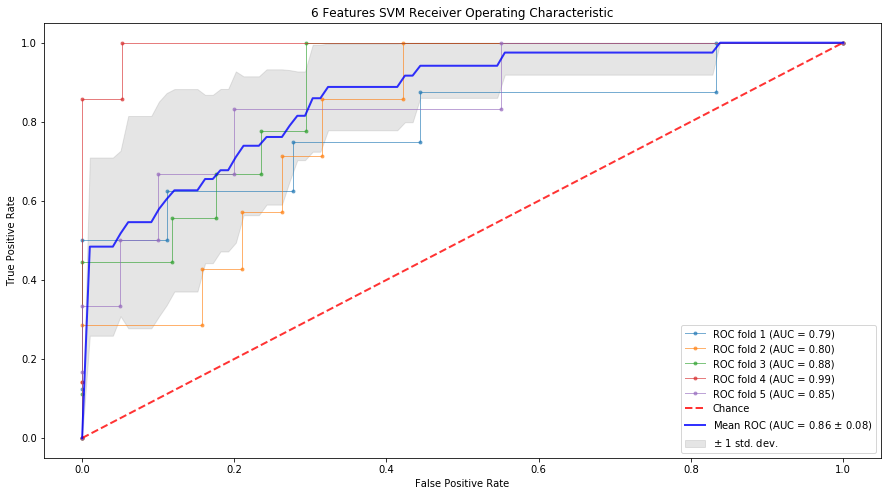

mean_tpr
 [0.         0.48412698 0.48412698 0.48412698 0.48412698 0.51746032
 0.54603175 0.54603175 0.54603175 0.54603175 0.57936508 0.60436508
 0.6265873  0.6265873  0.6265873  0.6265873  0.65515873 0.65515873
 0.67738095 0.67738095 0.71071429 0.73928571 0.73928571 0.73928571
 0.76150794 0.76150794 0.76150794 0.79007937 0.81507937 0.81507937
 0.85952381 0.85952381 0.88809524 0.88809524 0.88809524 0.88809524
 0.88809524 0.88809524 0.88809524 0.88809524 0.88809524 0.88809524
 0.91666667 0.91666667 0.94166667 0.94166667 0.94166667 0.94166667
 0.94166667 0.94166667 0.94166667 0.94166667 0.94166667 0.94166667
 0.94166667 0.975      0.975      0.975      0.975      0.975
 0.975      0.975      0.975      0.975      0.975      0.975
 0.975      0.975      0.975      0.975      0.975      0.975
 0.975      0.975      0.975      0.975      0.975      0.975
 0.975      0.975      0.975      0.975      0.975      1.
 1.         1.         1.         1.         1.         1.
 1.         1.       

In [24]:
# Train SVC.


kernel_options = {1: "rbf", 2: "linear"}
kernel_SVC = 2
# Run SVM Classifier.
ppvs, npvs, sensitivitys, specificitys = [], [], [], []
best_clf_SVC = None

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)


for i in np.arange(0, n_fold): 
    print("------------------------ Fold %d --------------------------" %(i+1)) 

    X_train, X_test = X[train_fold_mask[i]], X[val_fold_mask[i]]

    X_train, X_test = scaler.fit_transform(X_train), scaler.transform(X_test)
    asm_train, asm_test = asm[train_fold_mask[i]], asm[val_fold_mask[i]] 
    asm_h2_train, asm_h2_test = asm_h2[train_fold_mask[i]], asm_h2[val_fold_mask[i]]
    sarcopenia_train, sarcopenia_test = sarcopenia[train_fold_mask[i]], sarcopenia[val_fold_mask[i]]
    gender_train, gender_test = gender[train_fold_mask[i]], gender[val_fold_mask[i]]
    height_squared_train, height_squared_test = height_squared[train_fold_mask[i]], height_squared[val_fold_mask[i]]
    patient_id_train, patient_id_test = patient_id[train_fold_mask[i]], patient_id[val_fold_mask[i]]
    #print(patient_id_train, patient_id_test)
    
    best_clf_SVC = run_SVC_k_fold(X_train, sarcopenia_train, kernel=kernel_options[kernel_SVC], log=use_log, dont_show=True)
    
    #observe_prediction_SVC(best_clf_SVC, X_train, sarcopenia_train, patient_id_train, dont_show=True, log=use_log, setname='Training')
    #result_train_SVC = best_clf_SVC.predict(X_train)
    #eval_classifier(result_train_SVC, sarcopenia_train, show_detail=False, log=use_log, setname='Training')

    observe_prediction_SVC(best_clf_SVC, X_test, sarcopenia_test, patient_id_test, dont_show=True, log=use_log, setname='Test')
    result_test_SVC = best_clf_SVC.predict(X_test)
    eval_classifier(result_test_SVC, sarcopenia_test, show_detail=True, log=use_log, setname='Test')
    
    ppv, npv, sensitivity, specificity = eval_classifier_k_fold(result_test_SVC, sarcopenia_test)
    ppvs.append(ppv); npvs.append(npv); sensitivitys.append(sensitivity); specificitys.append(specificity);
    
    # Plot ROC Curve
    probs = best_clf_SVC.predict_proba(X_test)
    probs = probs[:, 1]
    fpr, tpr, thresholds = roc_curve(sarcopenia_test, probs)
    print(fpr)
    print(tpr)
    print(thresholds)
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.6, marker='.',
             label='ROC fold %d (AUC = %0.2f)' % (i+1, roc_auc))
    
print("------------------------ Overall Statistics --------------------------") 
print("ppv: %.3f +/- %.3f, \nnpv: %.3f +/- %.3f, \nsensitivity: %.3f +/- %.3f, \nspecificity: %.3f +/- %.3f\n" % 
      (np.mean(ppvs), np.std(ppvs, ddof=1), np.mean(npvs), np.std(npvs, ddof=1), np.mean(sensitivitys), np.std(sensitivitys, ddof=1), np.mean(specificitys), np.std(specificitys, ddof=1)))

# Plot ROC Curve

plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs, ddof=1)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0, ddof=1)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('%d Features SVM Receiver Operating Characteristic' % (len(include_feature_index)))
plt.legend(loc="lower right")
plt.show()


print("mean_tpr\n", mean_tpr)
print("mean_fpr\n", mean_fpr)
print("tprs_lower\n", tprs_lower)
print("tprs_upper\n", tprs_upper)

## Method II: SVM Regressor on asm/h2 (k-fold)

In [104]:
# Train SVR on asm/h2.
kernel_options = {1: "rbf", 2: "linear"}
kernel_SVR = 2

ppvs, npvs, sensitivitys, specificitys = [], [], [], []
for i in np.arange(0, n_fold): 
    print("------------------------ Fold %d --------------------------" %(i+1)) 

    X_train, X_test = X[train_fold_mask[i]], X[val_fold_mask[i]]

    X_train, X_test = scaler.fit_transform(X_train), scaler.transform(X_test)
    asm_train, asm_test = asm[train_fold_mask[i]], asm[val_fold_mask[i]] 
    asm_h2_train, asm_h2_test = asm_h2[train_fold_mask[i]], asm_h2[val_fold_mask[i]]
    sarcopenia_train, sarcopenia_test = sarcopenia[train_fold_mask[i]], sarcopenia[val_fold_mask[i]]
    gender_train, gender_test = gender[train_fold_mask[i]], gender[val_fold_mask[i]]
    height_squared_train, height_squared_test = height_squared[train_fold_mask[i]], height_squared[val_fold_mask[i]]
    patient_id_train, patient_id_test = patient_id[train_fold_mask[i]], patient_id[val_fold_mask[i]]

    
    best_clf_asm_h2_SVR = run_SVR_k_fold(X_train, asm_h2_train, kernel=kernel_options[kernel_SVR], log=use_log, dont_show=True)
    # Training Set:
    #observe_prediction_asm_h2_SVR(best_clf_asm_h2_SVR, X_train, asm_h2_train, gender_train, sarcopenia_train, patient_id_train, dont_show=True, log=use_log, setname='Training')
    #result_train_asm_h2_SVR = eval_sarcopenia_asm_h2(best_clf_asm_h2_SVR, X_train, gender_train, sarcopenia_train)
    #eval_classifier(result_train_asm_h2_SVR, sarcopenia_train, show_detail=False, log=use_log, setname='Training')

    #Test Set:
    observe_prediction_asm_h2_SVR(best_clf_asm_h2_SVR, X_test, asm_h2_test, gender_test, sarcopenia_test, patient_id_test, dont_show=True, log=use_log, setname='Test')
    result_test_asm_h2_SVR = eval_sarcopenia_asm_h2(best_clf_asm_h2_SVR, X_test, gender_test, sarcopenia_test)
    eval_classifier(result_test_asm_h2_SVR, sarcopenia_test, show_detail=True, log=use_log, setname='Test')

    ppv, npv, sensitivity, specificity = eval_classifier_k_fold(result_test_asm_h2_SVR, sarcopenia_test)
    ppvs.append(ppv); npvs.append(npv); sensitivitys.append(sensitivity); specificitys.append(specificity);
    

print("------------------------ Overall Statistics --------------------------") 
print("ppv: %.3f +/- %.3f, \nnpv: %.3f +/- %.3f, \nsensitivity: %.3f +/- %.3f, \nspecificity: %.3f +/- %.3f\n" % 
      (np.mean(ppvs), np.std(ppvs, ddof=1), np.mean(npvs), np.std(npvs, ddof=1), np.mean(sensitivitys), np.std(sensitivitys, ddof=1), np.mean(specificitys), np.std(specificitys, ddof=1)))



------------------------ Fold 1 --------------------------

Evaluating Test set:
Positive: 9, Negative: 17
TP: 3, FP: 0, TN: 17, FN: 6
Correct: 20(26), Precision: 1.000, Recall: 0.333, Specificity: 1.000, F1-Score: 0.500

------------------------ Fold 2 --------------------------

Evaluating Test set:
Positive: 8, Negative: 18
TP: 3, FP: 0, TN: 18, FN: 5
Correct: 21(26), Precision: 1.000, Recall: 0.375, Specificity: 1.000, F1-Score: 0.545

------------------------ Fold 3 --------------------------

Evaluating Test set:
Positive: 6, Negative: 20
TP: 4, FP: 2, TN: 18, FN: 2
Correct: 22(26), Precision: 0.667, Recall: 0.667, Specificity: 0.900, F1-Score: 0.667

------------------------ Fold 4 --------------------------

Evaluating Test set:
Positive: 7, Negative: 19
TP: 4, FP: 1, TN: 18, FN: 3
Correct: 22(26), Precision: 0.800, Recall: 0.571, Specificity: 0.947, F1-Score: 0.667

------------------------ Fold 5 --------------------------

Evaluating Test set:
Positive: 6, Negative: 20
TP: 5

## Method III: SVM Regressor on asm (k-fold)

In [8]:
# Train SVR on asm.
kernel_options = {1: "rbf", 2: "linear"}
kernel_SVR = 2

ppvs, npvs, sensitivitys, specificitys = [], [], [], []
for i in np.arange(0, n_fold): 
    print("------------------------ Fold %d --------------------------" %(i+1)) 

    X_train, X_test = X[train_fold_mask[i]], X[val_fold_mask[i]]
    X_train, X_test = scaler.fit_transform(X_train), scaler.transform(X_test)
    
    asm_train, asm_test = asm[train_fold_mask[i]], asm[val_fold_mask[i]] 
    asm_h2_train, asm_h2_test = asm_h2[train_fold_mask[i]], asm_h2[val_fold_mask[i]]
    sarcopenia_train, sarcopenia_test = sarcopenia[train_fold_mask[i]], sarcopenia[val_fold_mask[i]]
    gender_train, gender_test = gender[train_fold_mask[i]], gender[val_fold_mask[i]]
    height_squared_train, height_squared_test = height_squared[train_fold_mask[i]], height_squared[val_fold_mask[i]]
    patient_id_train, patient_id_test = patient_id[train_fold_mask[i]], patient_id[val_fold_mask[i]]
        
    # Train Regressor
    best_clf_asm_SVR = run_SVR_k_fold(X_train, asm_train, kernel=kernel_options[kernel_SVR], log=use_log, dont_show=True)
    
    # Training Set:
    #observe_prediction_asm_SVR(best_clf_asm_SVR, X_train, asm_train, gender_train, height_squared_train, sarcopenia_train, patient_id_train, dont_show=True, log=use_log, setname='Training')
    #result_train_asm_SVR = eval_sarcopenia_asm(best_clf_asm_SVR, X_train, gender_train, height_squared_train, sarcopenia_train)
    #eval_classifier(result_train_asm_SVR, sarcopenia_train, show_detail=False, log=use_log, setname='Training')
    # Test Set:
    observe_prediction_asm_SVR(best_clf_asm_SVR, X_test, asm_test, gender_test, height_squared_test, sarcopenia_test, patient_id_test, dont_show=True, log=use_log, setname='Test')
    result_test_asm_SVR = eval_sarcopenia_asm(best_clf_asm_SVR, X_test, gender_test, height_squared_test, sarcopenia_test)
    eval_classifier(result_test_asm_SVR, sarcopenia_test, show_detail=True, log=use_log, setname='Test')

    ppv, npv, sensitivity, specificity = eval_classifier_k_fold(result_test_asm_SVR, sarcopenia_test)
    ppvs.append(ppv); npvs.append(npv); sensitivitys.append(sensitivity); specificitys.append(specificity);
    

print("------------------------ Overall Statistics --------------------------") 
print("ppv: %.3f +/- %.2f, \nnpv: %.3f +/- %.2f, \nsensitivity: %.3f +/- %.2f, \nspecificity: %.3f +/- %.2f\n" % 
      (np.mean(ppvs), np.std(ppvs, ddof=1), np.mean(npvs), np.std(npvs, ddof=1), np.mean(sensitivitys), np.std(sensitivitys, ddof=1), np.mean(specificitys), np.std(specificitys, ddof=1)))


------------------------ Fold 1 --------------------------

Evaluating Test set:
Positive: 7, Negative: 19
TP: 3, FP: 0, TN: 19, FN: 4
Correct: 22(26), Precision: 1.000, Recall: 0.429, Specificity: 1.000, F1-Score: 0.600

------------------------ Fold 2 --------------------------

Evaluating Test set:
Positive: 7, Negative: 19
TP: 4, FP: 0, TN: 19, FN: 3
Correct: 23(26), Precision: 1.000, Recall: 0.571, Specificity: 1.000, F1-Score: 0.727

------------------------ Fold 3 --------------------------

Evaluating Test set:
Positive: 8, Negative: 18
TP: 3, FP: 1, TN: 17, FN: 5
Correct: 20(26), Precision: 0.750, Recall: 0.375, Specificity: 0.944, F1-Score: 0.500

------------------------ Fold 4 --------------------------

Evaluating Test set:
Positive: 8, Negative: 18
TP: 4, FP: 4, TN: 14, FN: 4
Correct: 18(26), Precision: 0.500, Recall: 0.500, Specificity: 0.778, F1-Score: 0.500

------------------------ Fold 5 --------------------------

Evaluating Test set:
Positive: 7, Negative: 19
TP: 2

## Measurement Index
$$Precision = \frac{True\ Positive}{True\ Positve + False\ Positive}$$
$$Recall = \frac{True\ Positive}{True\ Positive + False\ Negative}$$
$$F1\_Score = \frac{2 \times Precision \times Recall}{Precision + Recall}$$

$$PPV = \frac{True\ Positive}{True\ Positve + False\ Positive}$$
$$NPV = \frac{True\ Negative}{True\ Negative + False\ Negative}$$
$$Sensitivity = \frac{True\ Positive}{True\ Positive + False\ Negative}$$
$$Specificity = \frac{True\ Negative}{True\ Negative + False\ Positive}$$


|       |          | Actual   | Class  |
| :---  | ---      | ---      |    --- |
|       |          | Positive |Negative|
|Predict|Positive  | TP       | FP     |
| Class |Negative  | FN       | TN     |
